In [1]:
import argparse
import errno
import os
import random
from importlib.metadata import requires
from timeit import timeit
import dill as pickle
import numpy as np
import scipy
import torch
import wandb
import yaml
from sympy import Matrix, MatrixSymbol, derive_by_array, symarray
from torch.distributions import Categorical

from subrl.utils.environment import GridWorld
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from visualization import Visu

# TODO: 1. remove dependence from matrix and could run multiple times in parallel, .sh script, run it on the server, check how to plot multiple on wb,
# can it plot different kappa's on the same with grouping
# apply a policy gradient algorithm, since the policy is deterministic, use policy iteration/value iteration since we know the dynamics
#
workspace = "subrl"

# 1) Load the config file
with open(workspace + "/params/" + "coverage/subrl_NM" + ".yaml") as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
print(params)

# 2) Set the path and copy params from file
env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_" + \
    str(1)

params['env']['num'] = 1 

epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)

# 3) Setup the environement
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])

env.get_horizon_transition_matrix()


/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'env': {'start': 1, 'step_size': 0.1, 'shape': {'x': 30, 'y': 30}, 'horizon': 80, 'node_weight': 'constant', 'disc_size': 'small', 'n_players': 3, 'Cx_lengthscale': 2, 'Cx_noise': 0.001, 'Fx_lengthscale': 1, 'Fx_noise': 0.001, 'Cx_beta': 1.5, 'Fx_beta': 1.5, 'generate': False, 'env_file_name': 'env_data.pkl', 'cov_module': 'Matern', 'stochasticity': 0.0, 'domains': 'single_room'}, 'alg': {'gamma': 1, 'type': 'NM', 'ent_coef': 0.0, 'epochs': 50, 'lr': 0.01}, 'common': {'a': 1, 'subgrad': 'greedy', 'grad': 'pytorch', 'algo': 'both', 'init': 'deterministic', 'batch_size': 500}, 'visu': {'wb': 'online', 'a': 1}}
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001, 18.4999, 18.5001, 19.4999, 19.5001, 20.4999, 20.5001

In [2]:
def train():
    # Agent's policy
    if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
        agent = agent_net(2, env.action_dim)
    else:
        agent = agent_net(H-1, env.action_dim)
    optim = torch.optim.Adam(agent.parameters(), lr=params["alg"]["lr"])

    for t_eps in range(epochs):
        mat_action = []
        mat_state = []
        mat_return = []
        marginal_return = []
        mat_done = []
        # print(t_eps)
        env.initialize()
        mat_state.append(env.state)
        init_state = env.state
        list_batch_state = []
        for h_iter in range(H-1):
            if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
                batch_state = mat_state[-1].reshape(-1, 1).float()
                # append time index to the state
                batch_state = torch.cat(
                    [batch_state, h_iter*torch.ones_like(batch_state)], 1)
            else:
                batch_state = append_state(mat_state, H-1)
            action_prob = agent(batch_state)
            policy_dist = Categorical(action_prob)
            actions = policy_dist.sample()
            mat_action.append(actions)
            env.step(h_iter, actions)
            mat_state.append(env.state)  # s+1
            mat_return.append(env.weighted_traj_return(mat_state, type = params["alg"]["type"]))
            if h_iter ==0:
                marginal_return.append(mat_return[h_iter])
            else:
                marginal_return.append(mat_return[h_iter] - mat_return[h_iter-1])
            list_batch_state.append(batch_state)

        ###################
        # Compute gradients
        ###################

        states_visited = torch.vstack(list_batch_state).float()
    
        policy_dist = Categorical(agent(states_visited))
        log_prob = policy_dist.log_prob(torch.hstack(mat_action))
        batch_return = torch.hstack(marginal_return)/MAX_Ret

        # - 2*policy_dist.entropy().mean()
        J_obj = -1*(torch.mean(log_prob*batch_return) + params["alg"]["ent_coef"] *
                    policy_dist.entropy().mean()/(t_eps+1))
        optim.zero_grad()
        J_obj.backward()
        optim.step()

        obj = env.weighted_traj_return(mat_state).float()
        print(visu.JPi_optimal, " mean ", obj.mean(), " max ",
            obj.max(), " median ", obj.median(), " min ", obj.min(), " ent ", policy_dist.entropy().mean().detach())
    return agent

In [3]:
min_return = []
max_return = []
mean_return = []
median_return = []
for iter in range(10):
    # params["common"]["batch_size"]=1000
    agent = train()
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, H-1)
        action_prob = agent(batch_state)
        policy_dist = Categorical(action_prob)
        actions = policy_dist.sample()
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    returns = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float()
    min_return.append(returns.min())
    max_return.append(returns.max())
    mean_return.append(returns.mean())
    median_return.append(returns.median())
mean_min_return = np.mean(min_return)
std_min_return = np.std(min_return)
mean_max_return = np.mean(max_return)
std_max_return = np.std(max_return)
mean_mean_return = np.mean(mean_return)
std_mean_return = np.std(mean_return)
mean_median_return = np.mean(median_return)
std_median_return = np.std(median_return)
print(f"min: {mean_min_return:.2f}±{std_min_return:.2f}, max: {mean_max_return:.2f}±{std_max_return:.2f}, mean: {mean_mean_return:.2f}±{std_mean_return:.2f}, median: {mean_median_return:.2f}±{std_median_return:.2f}")

None  mean  tensor(50.5480)  max  tensor(97.)  median  tensor(50.)  min  tensor(21.)  ent  tensor(1.5860)
None  mean  tensor(88.6820)  max  tensor(114.)  median  tensor(90.)  min  tensor(51.)  ent  tensor(1.4207)
None  mean  tensor(87.3740)  max  tensor(115.)  median  tensor(87.)  min  tensor(72.)  ent  tensor(1.1052)
None  mean  tensor(82.7300)  max  tensor(105.)  median  tensor(82.)  min  tensor(68.)  ent  tensor(0.9016)
None  mean  tensor(83.2380)  max  tensor(103.)  median  tensor(83.)  min  tensor(66.)  ent  tensor(0.8173)
None  mean  tensor(88.6900)  max  tensor(115.)  median  tensor(89.)  min  tensor(71.)  ent  tensor(0.8187)
None  mean  tensor(99.0840)  max  tensor(122.)  median  tensor(99.)  min  tensor(81.)  ent  tensor(0.8453)
None  mean  tensor(104.8720)  max  tensor(123.)  median  tensor(105.)  min  tensor(87.)  ent  tensor(0.8321)
None  mean  tensor(100.1500)  max  tensor(115.)  median  tensor(101.)  min  tensor(81.)  ent  tensor(0.7716)
None  mean  tensor(93.5300)  max  

In [2]:
from tqdm import tqdm

def train_2():
    # Agent's policy
    if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
        agent = agent_net(2, env.action_dim)
    else:
        agent = agent_net(H-1, env.action_dim)
    optim = torch.optim.Adam(agent.parameters(), lr=params["alg"]["lr"])

    # 记录每个epoch的奖励
    epoch_rewards = []
    
    # 添加进度条
    epoch_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    for t_eps in epoch_bar:
        mat_action = []
        mat_state = []
        mat_return = []
        marginal_return = []
        mat_done = []
        # print(t_eps)
        env.initialize()
        mat_state.append(env.state)
        init_state = env.state
        list_batch_state = []
        for h_iter in range(H-1):
            if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
                batch_state = mat_state[-1].reshape(-1, 1).float()
                # append time index to the state
                batch_state = torch.cat(
                    [batch_state, h_iter*torch.ones_like(batch_state)], 1)
            else:
                batch_state = append_state(mat_state, H-1)
            action_prob = agent(batch_state)
            policy_dist = Categorical(action_prob)
            actions = policy_dist.sample()
            mat_action.append(actions)
            env.step(h_iter, actions)
            mat_state.append(env.state)  # s+1
            mat_return.append(env.weighted_traj_return(mat_state, type = params["alg"]["type"]))
            if h_iter ==0:
                marginal_return.append(mat_return[h_iter])
            else:
                marginal_return.append(mat_return[h_iter] - mat_return[h_iter-1])
            list_batch_state.append(batch_state)

        ###################
        # Compute gradients
        ###################

        states_visited = torch.vstack(list_batch_state).float()
    
        policy_dist = Categorical(agent(states_visited))
        log_prob = policy_dist.log_prob(torch.hstack(mat_action))
        batch_return = torch.hstack(marginal_return)/MAX_Ret

        # - 2*policy_dist.entropy().mean()
        J_obj = -1*(torch.mean(log_prob*batch_return) + params["alg"]["ent_coef"] *
                    policy_dist.entropy().mean()/(t_eps+1))
        optim.zero_grad()
        J_obj.backward()
        optim.step()

        obj = env.weighted_traj_return(mat_state).float()
        current_reward_mean = obj.mean().item()
        epoch_rewards.append(current_reward_mean)
        
        # 更新进度条显示信息
        epoch_bar.set_postfix({
            'mean': f'{current_reward_mean:.3f}',
            'max': f'{obj.max():.3f}',
            'min': f'{obj.min():.3f}',
            'median': f'{obj.median():.3f}',
            'entropy': f'{policy_dist.entropy().mean().detach():.3f}'
        })
        
        # 注释掉原来的print语句
        # print(visu.JPi_optimal, " mean ", obj.mean(), " max ",
        #     obj.max(), " median ", obj.median(), " min ", obj.min(), " ent ", policy_dist.entropy().mean().detach())
    
    epoch_bar.close()
    
    return agent, epoch_rewards

In [3]:
min_return = []
max_return = []
mean_return = []
median_return = []
epoch_rewards_all = []
for iter in range(10):
    # params["common"]["batch_size"]=1000
    agent, epoch_rewards = train_2()
    epoch_rewards_all.append(epoch_rewards)
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, H-1)
        action_prob = agent(batch_state)
        policy_dist = Categorical(action_prob)
        actions = policy_dist.sample()
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    returns = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float()
    min_return.append(returns.min())
    max_return.append(returns.max())
    mean_return.append(returns.mean())
    median_return.append(returns.median())
mean_min_return = np.mean(min_return)
std_min_return = np.std(min_return)
mean_max_return = np.mean(max_return)
std_max_return = np.std(max_return)
mean_mean_return = np.mean(mean_return)
std_mean_return = np.std(mean_return)
mean_median_return = np.mean(median_return)
std_median_return = np.std(median_return)
print(f"min: {mean_min_return:.2f}±{std_min_return:.2f}, max: {mean_max_return:.2f}±{std_max_return:.2f}, mean: {mean_mean_return:.2f}±{std_mean_return:.2f}, median: {mean_median_return:.2f}±{std_median_return:.2f}")

Training: 100%|██████████| 50/50 [00:31<00:00,  1.61epoch/s, mean=81.944, max=102.000, min=64.000, median=82.000, entropy=0.600]  

min: 84.00±8.94, max: 120.10±19.25, mean: 106.87±15.70, median: 108.10±16.66


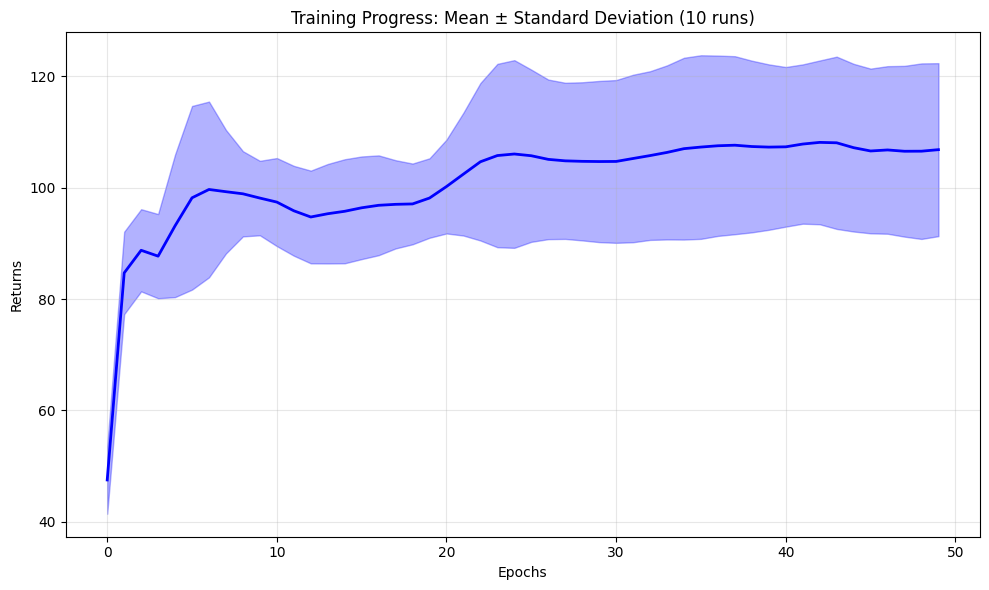

最终epoch的均值: 106.833 ± 15.540
最大均值: 108.141 (epoch 42)
训练开始时均值: 47.492 ± 6.080


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 使用epoch_rewards_all计算均值和标准差
epoch_rewards_array = np.array(epoch_rewards_all)  # shape: (10, epochs)
mean_rewards = np.mean(epoch_rewards_array, axis=0)  # 每个epoch的均值
std_rewards = np.std(epoch_rewards_array, axis=0)   # 每个epoch的标准差

# 创建x轴（epoch数）
epochs_range = range(len(mean_rewards))

# 绘制均值±标准差图
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, mean_rewards, 'b-', label='Mean', linewidth=2)
plt.fill_between(epochs_range, 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 alpha=0.3, color='blue', label='±1 std')

plt.xlabel('Epochs')
plt.ylabel('Returns')
plt.title('Training Progress: Mean ± Standard Deviation (10 runs)')
# plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 打印一些统计信息
print(f"最终epoch的均值: {mean_rewards[-1]:.3f} ± {std_rewards[-1]:.3f}")
print(f"最大均值: {np.max(mean_rewards):.3f} (epoch {np.argmax(mean_rewards)})")
print(f"训练开始时均值: {mean_rewards[0]:.3f} ± {std_rewards[0]:.3f}")

In [5]:
import pickle

with open('one_room_data/epoch_rewards_subrl.pkl', 'wb') as f:
    pickle.dump(epoch_rewards_all, f)
print("epoch_rewards_all 已保存为 one_room_data/epoch_rewards_subrl.pkl")

epoch_rewards_all 已保存为 one_room_data/epoch_rewards_subrl.pkl
